<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [2]:
# import os
# if not os.path.exists('GEOMAR-DeepLearning'):
#     print(f'GEOMAR-DeepLearning does not exist')
#     !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt
# else:
#     print(f'GEOMAR-DeepLearning exists')
#     %cd GEOMAR-DeepLearning/app/backend
#     !git pull
#     !pip install -r requirements.txt

## Import Libaries

In [3]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
import folium
from tqdm import tqdm
from utils.OpenMeteoWeather import OpenMeteoWeather

from datetime import datetime
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

/home/marco/venv/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

In [4]:
START_DATE = '2025-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    
    "minimum_longitude":9.10,
    "maximum_longitude":30.20,
    "minimum_latitude":53.10,
    "maximum_latitude":65.00,

    # "minimum_longitude":9.85083510071235,
    # "maximum_longitude":10.926709174713364,
    # "minimum_latitude":54.25206332481298,
    # "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [5]:
# Download Data
minimum_latitude = BBOX['minimum_latitude']
maximum_latitude = BBOX['maximum_latitude']
minimum_longitude = BBOX['minimum_longitude']
maximum_longitude = BBOX['maximum_longitude']

copernicus = AdvancedCopernicus()

latitudes = np.linspace(minimum_latitude, maximum_latitude, 10)
longitudes = np.linspace(minimum_longitude, maximum_longitude, 10)

In [6]:
# zip latitudes and longitudes
coordinates = set([(float(lat), float(lon)) for lat in latitudes for lon in longitudes])

# plot the coordinates to folium
folium_map = folium.Map(location=[minimum_latitude, minimum_longitude], zoom_start=10)
for lat, lon in coordinates:
    folium.CircleMarker(location=[lat, lon], radius=5, color='red').add_to(folium_map)
folium_map

In [7]:


# Calculate Radius
radius = 0.001

variables = ["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"]
df_ocean = pd.DataFrame()
for lat, lon in tqdm(coordinates, total=len(coordinates)):
    print(lat, lon)
    file = f'output_filename_{lat, lon}.nc'

    if file in os.listdir():
        data = xr.open_dataset(file)
        data = data.to_dataframe().reset_index()
        df_ocean = pd.concat([df_ocean, data], axis=0)
    else:
        data = copernicus.get_subset(
            dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
            dataset_version="202411",
            variables=variables,
            minimum_longitude=lon-radius,
            maximum_longitude=lon+radius,
            minimum_latitude=lat-radius,
            maximum_latitude=lat+radius,
    
            start_datetime=START_DATE,
            end_datetime=END_DATE,
            minimum_depth=0.5016462206840515,
            maximum_depth=0.5016462206840515,
            coordinates_selection_method="strict-inside",
            disable_progress_bar=False,
            output_filename=file,
            delete_file=False)
    
    
    
        data = data.to_dataframe().reset_index()
        df_ocean = pd.concat([df_ocean, data], axis=0)

print(df_ocean.info())
display(df_ocean.head())

  1%|          | 1/100 [00:00<00:18,  5.33it/s]

53.1 18.477777777777778
57.06666666666667 16.133333333333333


  3%|▎         | 3/100 [00:00<00:12,  7.61it/s]

54.422222222222224 18.477777777777778
61.03333333333333 20.822222222222223


  5%|▌         | 5/100 [00:00<00:10,  8.64it/s]

55.74444444444445 18.477777777777778
57.06666666666667 11.444444444444445


  7%|▋         | 7/100 [00:00<00:10,  8.69it/s]

62.355555555555554 20.822222222222223
61.03333333333333 9.1


  8%|▊         | 8/100 [00:01<00:13,  6.71it/s]

65.0 27.855555555555554


 10%|█         | 10/100 [00:01<00:15,  5.93it/s]

58.388888888888886 13.788888888888888
63.67777777777778 20.822222222222223


 12%|█▏        | 12/100 [00:01<00:15,  5.60it/s]

65.0 30.2
58.388888888888886 16.133333333333333


 14%|█▍        | 14/100 [00:02<00:13,  6.59it/s]

62.355555555555554 9.1
59.71111111111111 13.788888888888888


 16%|█▌        | 16/100 [00:02<00:10,  7.64it/s]

59.71111111111111 16.133333333333333
61.03333333333333 25.511111111111113


 18%|█▊        | 18/100 [00:02<00:10,  7.81it/s]

63.67777777777778 9.1
53.1 23.166666666666664


 20%|██        | 20/100 [00:02<00:10,  7.85it/s]

62.355555555555554 25.511111111111113
54.422222222222224 23.166666666666664


 22%|██▏       | 22/100 [00:03<00:09,  8.47it/s]

58.388888888888886 18.477777777777778
63.67777777777778 25.511111111111113


 24%|██▍       | 24/100 [00:03<00:10,  7.22it/s]

55.74444444444445 23.166666666666664
59.71111111111111 18.477777777777778


 26%|██▌       | 26/100 [00:03<00:09,  8.07it/s]

65.0 16.133333333333333
61.03333333333333 27.855555555555554


 27%|██▋       | 27/100 [00:03<00:08,  8.13it/s]

61.03333333333333 30.2


 29%|██▉       | 29/100 [00:04<00:09,  7.19it/s]

62.355555555555554 27.855555555555554
65.0 11.444444444444445


 31%|███       | 31/100 [00:04<00:10,  6.89it/s]

62.355555555555554 30.2
63.67777777777778 27.855555555555554


 33%|███▎      | 33/100 [00:04<00:09,  7.17it/s]

57.06666666666667 13.788888888888888
58.388888888888886 23.166666666666664


 35%|███▌      | 35/100 [00:04<00:09,  7.22it/s]

63.67777777777778 30.2
59.71111111111111 23.166666666666664


 37%|███▋      | 37/100 [00:05<00:08,  7.15it/s]

55.74444444444445 30.2
53.1 20.822222222222223


 39%|███▉      | 39/100 [00:05<00:09,  6.52it/s]

57.06666666666667 18.477777777777778
54.422222222222224 20.822222222222223


 41%|████      | 41/100 [00:05<00:07,  7.51it/s]

61.03333333333333 16.133333333333333
53.1 9.1


 43%|████▎     | 43/100 [00:05<00:06,  8.42it/s]

55.74444444444445 20.822222222222223
62.355555555555554 16.133333333333333


 44%|████▍     | 44/100 [00:06<00:06,  8.43it/s]

54.422222222222224 9.1


 46%|████▌     | 46/100 [00:06<00:07,  7.12it/s]

61.03333333333333 11.444444444444445
63.67777777777778 16.133333333333333


 48%|████▊     | 48/100 [00:06<00:06,  7.58it/s]

53.1 25.511111111111113
55.74444444444445 9.1


 50%|█████     | 50/100 [00:06<00:06,  8.05it/s]

62.355555555555554 11.444444444444445
54.422222222222224 25.511111111111113


 52%|█████▏    | 52/100 [00:07<00:06,  7.13it/s]

63.67777777777778 11.444444444444445
55.74444444444445 25.511111111111113


 54%|█████▍    | 54/100 [00:07<00:06,  7.00it/s]

57.06666666666667 23.166666666666664
65.0 13.788888888888888


 56%|█████▌    | 56/100 [00:07<00:05,  7.56it/s]

58.388888888888886 20.822222222222223
59.71111111111111 20.822222222222223


 58%|█████▊    | 58/100 [00:07<00:05,  7.50it/s]

53.1 27.855555555555554
53.1 30.2


 60%|██████    | 60/100 [00:08<00:06,  6.55it/s]

59.71111111111111 9.1
65.0 18.477777777777778


 62%|██████▏   | 62/100 [00:08<00:05,  7.18it/s]

54.422222222222224 27.855555555555554
54.422222222222224 30.2


 64%|██████▍   | 64/100 [00:08<00:04,  7.68it/s]

58.388888888888886 25.511111111111113
55.74444444444445 27.855555555555554


 66%|██████▌   | 66/100 [00:09<00:04,  7.81it/s]

59.71111111111111 25.511111111111113
61.03333333333333 13.788888888888888


 68%|██████▊   | 68/100 [00:09<00:04,  7.93it/s]

62.355555555555554 13.788888888888888
63.67777777777778 13.788888888888888


 70%|███████   | 70/100 [00:09<00:03,  8.23it/s]

53.1 16.133333333333333
65.0 23.166666666666664


 72%|███████▏  | 72/100 [00:09<00:03,  8.28it/s]

57.06666666666667 20.822222222222223
58.388888888888886 30.2


 74%|███████▍  | 74/100 [00:10<00:04,  6.48it/s]

54.422222222222224 16.133333333333333
61.03333333333333 18.477777777777778


 76%|███████▌  | 76/100 [00:10<00:03,  7.25it/s]

53.1 11.444444444444445
59.71111111111111 30.2


 78%|███████▊  | 78/100 [00:10<00:02,  8.02it/s]

55.74444444444445 16.133333333333333
57.06666666666667 9.1


 80%|████████  | 80/100 [00:10<00:02,  7.92it/s]

62.355555555555554 18.477777777777778
54.422222222222224 11.444444444444445


 82%|████████▏ | 82/100 [00:11<00:02,  8.00it/s]

63.67777777777778 18.477777777777778
55.74444444444445 11.444444444444445


 84%|████████▍ | 84/100 [00:11<00:01,  8.02it/s]

57.06666666666667 25.511111111111113
58.388888888888886 9.1


 86%|████████▌ | 86/100 [00:11<00:01,  8.25it/s]

61.03333333333333 23.166666666666664
62.355555555555554 23.166666666666664


 88%|████████▊ | 88/100 [00:11<00:01,  7.00it/s]

58.388888888888886 11.444444444444445


 89%|████████▉ | 89/100 [00:12<00:01,  6.97it/s]

63.67777777777778 23.166666666666664
57.06666666666667 27.855555555555554


 91%|█████████ | 91/100 [00:12<00:01,  6.93it/s]

59.71111111111111 11.444444444444445
57.06666666666667 30.2


 93%|█████████▎| 93/100 [00:12<00:01,  6.77it/s]

65.0 20.822222222222223
65.0 9.1


 95%|█████████▌| 95/100 [00:12<00:00,  7.03it/s]

53.1 13.788888888888888
58.388888888888886 27.855555555555554


 97%|█████████▋| 97/100 [00:13<00:00,  7.65it/s]

54.422222222222224 13.788888888888888
65.0 25.511111111111113


 98%|█████████▊| 98/100 [00:13<00:00,  7.82it/s]

59.71111111111111 27.855555555555554


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

55.74444444444445 13.788888888888888
<class 'pandas.core.frame.DataFrame'>
Index: 153500 entries, 0 to 1534
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   depth      153500 non-null  float32       
 1   latitude   153500 non-null  float32       
 2   longitude  153500 non-null  float32       
 3   time       153500 non-null  datetime64[ns]
 4   bottomT    35305 non-null   float32       
 5   mlotst     35305 non-null   float32       
 6   siconc     35305 non-null   float32       
 7   sithick    35305 non-null   float32       
 8   sla        35305 non-null   float32       
 9   so         35305 non-null   float32       
 10  sob        35305 non-null   float32       
 11  thetao     35305 non-null   float32       
 12  uo         35305 non-null   float32       
 13  vo         35305 non-null   float32       
 14  wo         35305 non-null   float32       
dtypes: datetime64[ns](1), float32(14)
memo

,depth,latitude,longitude,time,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,0.501646,53.091629,18.486076,2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.501646,53.091629,18.486076,2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.501646,53.091629,18.486076,2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.501646,53.091629,18.486076,2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.501646,53.091629,18.486076,2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def process_df(df):
    # df = df.dropna(axis=1, how="all")
    # df = df.dropna(axis=0, how="any")
    # drop cols with lot of missing values

    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [9]:
df_ocean = df_ocean.dropna(axis=1, thresh=0.1*len(df_ocean))
df_ocean = df_ocean.dropna(axis=0, how="any")
df_ocean = process_df(df_ocean)
df_ocean.info()
df_ocean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35305 entries, 0 to 35304
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       35305 non-null  datetime64[ns]
 1   depth      35305 non-null  float32       
 2   latitude   35305 non-null  float32       
 3   longitude  35305 non-null  float32       
 4   bottomT    35305 non-null  float32       
 5   mlotst     35305 non-null  float32       
 6   siconc     35305 non-null  float32       
 7   sithick    35305 non-null  float32       
 8   sla        35305 non-null  float32       
 9   so         35305 non-null  float32       
 10  sob        35305 non-null  float32       
 11  thetao     35305 non-null  float32       
 12  uo         35305 non-null  float32       
 13  vo         35305 non-null  float32       
 14  wo         35305 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 2.2 MB


,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-01-01 00:00:00,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-2.329682e-06
1,2025-01-01 01:00:00,0.501646,61.024834,20.819481,3.355591,47.650723,0.0,0.0,0.365438,5.469317,5.468922,3.450520,0.044993,0.055679,-1.003944e-06
2,2025-01-01 02:00:00,0.501646,61.024834,20.819481,3.356911,47.673931,0.0,0.0,0.388645,5.469635,5.469238,3.424505,0.044172,0.064939,-2.181966e-06
3,2025-01-01 03:00:00,0.501646,61.024834,20.819481,3.357597,47.697372,0.0,0.0,0.412088,5.469461,5.469524,3.400486,0.037705,0.068201,-4.637662e-07
4,2025-01-01 04:00:00,0.501646,61.024834,20.819481,3.357936,47.718788,0.0,0.0,0.433501,5.469115,5.469809,3.383074,0.022312,0.058901,8.831645e-07


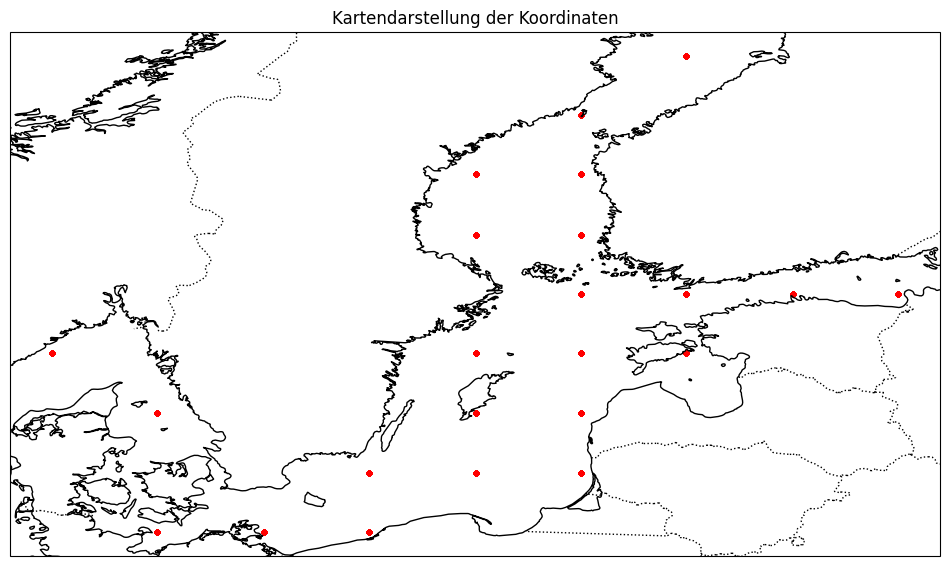

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Figure mit Kartenprojektion erstellen
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Küstenlinien und Länder hinzufügen
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Punkte plotten
ax.scatter(df_ocean['longitude'], df_ocean['latitude'], c='red', s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Achsen und Titel
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kartendarstellung der Koordinaten")

plt.show()


In [11]:
# Get unique latitudes and longitudes
coordinates = sorted(set(zip(df_ocean['latitude'], df_ocean['longitude'])))
print(f'Number of unique coordinates: {len(coordinates)}')

list(coordinates)

Number of unique coordinates: 23


[(54.42494201660156, 11.430461883544922),
 (54.42494201660156, 13.791563987731934),
 (54.42494201660156, 16.124893188476562),
 (55.7415885925293, 16.124893188476562),
 (55.7415885925293, 18.48607635498047),
 (55.7415885925293, 20.819480895996094),
 (57.05823516845703, 11.430461883544922),
 (57.05823516845703, 18.48607635498047),
 (57.05823516845703, 20.819480895996094),
 (58.39154052734375, 9.097137451171875),
 (58.39154052734375, 18.48607635498047),
 (58.39154052734375, 20.819480895996094),
 (58.39154052734375, 23.15288543701172),
 (59.708187103271484, 20.819480895996094),
 (59.708187103271484, 23.15288543701172),
 (59.708187103271484, 25.514068603515625),
 (59.708187103271484, 27.84747314453125),
 (61.02483367919922, 18.48607635498047),
 (61.02483367919922, 20.819480895996094),
 (62.35814666748047, 18.48607635498047),
 (62.35814666748047, 20.819480895996094),
 (63.6747932434082, 20.819480895996094),
 (64.9912109375, 23.15288543701172)]

In [12]:
dd

NameError: name 'dd' is not defined

In [13]:
latitudes = [lat for lat, lon in coordinates]
longitudes = [lon for lat, lon in coordinates]

    
print(latitudes, longitudes)
end_date_dt = datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")

#start_str = start_date_dt.strftime("%Y-%m-%d")
end_str = end_date_dt.strftime("%Y-%m-%d")
open_meteo_weather = OpenMeteoWeather(
    latitudes=latitudes,
    longitudes=longitudes,
    start_date=START_DATE,
    end_date=end_str
)
data = open_meteo_weather.get_weather_dataframe()

[54.42494201660156, 54.42494201660156, 54.42494201660156, 55.7415885925293, 55.7415885925293, 55.7415885925293, 57.05823516845703, 57.05823516845703, 57.05823516845703, 58.39154052734375, 58.39154052734375, 58.39154052734375, 58.39154052734375, 59.708187103271484, 59.708187103271484, 59.708187103271484, 59.708187103271484, 61.02483367919922, 61.02483367919922, 62.35814666748047, 62.35814666748047, 63.6747932434082, 64.9912109375] [11.430461883544922, 13.791563987731934, 16.124893188476562, 16.124893188476562, 18.48607635498047, 20.819480895996094, 11.430461883544922, 18.48607635498047, 20.819480895996094, 9.097137451171875, 18.48607635498047, 20.819480895996094, 23.15288543701172, 20.819480895996094, 23.15288543701172, 25.514068603515625, 27.84747314453125, 18.48607635498047, 20.819480895996094, 18.48607635498047, 20.819480895996094, 20.819480895996094, 23.15288543701172]


Processing weather data: 100%|██████████| 46/46 [00:00<00:00, 548.66it/s]


In [ ]:
# from utils.OpenMeteoWeather import OpenMeteoWeather

# from datetime import datetime
# # Konvertiere die Zeichenketten in Datetime-Objekte
# #start_date_dt = datetime.strptime(START_DATE, "%Y-%m-%d %H:%M:%S")
# end_date_dt = datetime.strptime(END_DATE, "%Y-%m-%d %H:%M:%S")

# #start_str = start_date_dt.strftime("%Y-%m-%d")
# end_str = end_date_dt.strftime("%Y-%m-%d")
# df = pd.DataFrame()
# for lat, lon in tqdm(coordinates, total=len(coordinates)):
#     print(lat, lon)

#     open_meteo_weather = OpenMeteoWeather(
#         latitudes=latitudes,
#         longitudes=longitudes,
#         start_date=START_DATE,
#         end_date=end_str
#     )
#     data = open_meteo_weather.get_weather_dataframe()
#     df = pd.concat([df, data], axis=0)
    


# print(df.info())
# display(df.head())

Processing weather data: 100%|██████████| 20/20 [00:00<00:00, 240.12it/s]


In [14]:

df_weather = data.copy()
ncols = len(df_weather.columns)

# drop cols with lot of missing values
df_weather = df_weather.dropna(axis=1, thresh=0.9*len(df_weather))
df_weather = df_weather.dropna(axis=0, how="any")
df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
Index: 35374 entries, 0 to 35879
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   latitude                    35374 non-null  float64       
 1   longitude                   35374 non-null  float64       
 2   time                        35374 non-null  datetime64[ns]
 3   temperature_2m              35374 non-null  float32       
 4   relative_humidity_2m        35374 non-null  float32       
 5   dew_point_2m                35374 non-null  float32       
 6   apparent_temperature        35374 non-null  float32       
 7   precipitation               35374 non-null  float32       
 8   rain                        35374 non-null  float32       
 9   showers                     35374 non-null  float32       
 10  snowfall                    35374 non-null  float32       
 11  weather_code                35374 non-null  float32       


,latitude,longitude,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,54.424942,11.430462,2024-12-31 23:00:00,3.80,88.977997,2.15,-5.254288,0.2,0.2,0.0,0.0,51.0,1010.599976,1010.599976,100.0,100.0,51.0,100.0,0.017204,0.088631,49.953808,218.563095,68.760002
1,54.424942,11.430462,2025-01-01 00:00:00,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
2,54.424942,11.430462,2025-01-01 01:00:00,4.65,88.108688,2.85,-4.481308,0.4,0.4,0.0,0.0,51.0,1008.099976,1008.099976,100.0,100.0,100.0,100.0,0.020372,0.101490,51.350502,222.300644,68.400002
3,54.424942,11.430462,2025-01-01 02:00:00,5.05,88.456490,3.30,-4.119362,0.6,0.6,0.0,0.0,53.0,1007.200012,1007.200012,100.0,100.0,100.0,100.0,0.020272,0.101308,52.190067,224.161682,70.199997
4,54.424942,11.430462,2025-01-01 03:00:00,5.45,88.491531,3.70,-3.849421,0.4,0.4,0.0,0.0,51.0,1006.299988,1006.299988,100.0,100.0,100.0,100.0,0.021022,0.103846,53.610092,226.768631,70.919998


In [15]:
cords = set(zip(df_weather['latitude'].astype(float), df_weather['longitude'].astype(float)))
cords

{(54.42494201660156, 11.430461883544922),
 (54.42494201660156, 13.791563987731934),
 (54.42494201660156, 16.124893188476562),
 (55.7415885925293, 16.124893188476562),
 (55.7415885925293, 18.48607635498047),
 (55.7415885925293, 20.819480895996094),
 (57.05823516845703, 11.430461883544922),
 (57.05823516845703, 18.48607635498047),
 (57.05823516845703, 20.819480895996094),
 (58.39154052734375, 9.097137451171875),
 (58.39154052734375, 18.48607635498047),
 (58.39154052734375, 20.819480895996094),
 (58.39154052734375, 23.15288543701172),
 (59.708187103271484, 20.819480895996094),
 (59.708187103271484, 23.15288543701172),
 (59.708187103271484, 25.514068603515625),
 (59.708187103271484, 27.84747314453125),
 (61.02483367919922, 18.48607635498047),
 (61.02483367919922, 20.819480895996094),
 (62.35814666748047, 18.48607635498047),
 (62.35814666748047, 20.819480895996094),
 (63.6747932434082, 20.819480895996094),
 (64.9912109375, 23.15288543701172)}

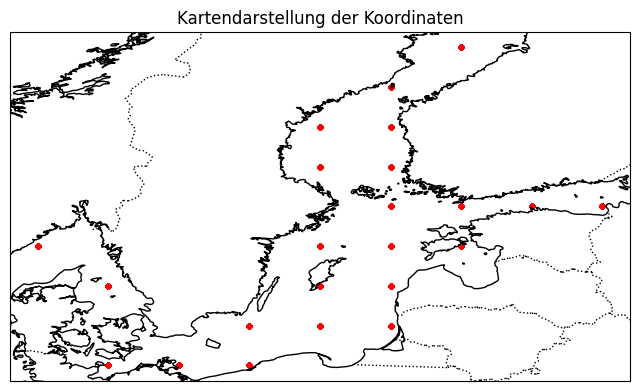

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Figure mit Kartenprojektion erstellen
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Küstenlinien und Länder hinzufügen
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Punkte plotten
ax.scatter(df_weather['longitude'], df_weather['latitude'], c='red', s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Achsen und Titel
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kartendarstellung der Koordinaten")

plt.show()

In [17]:
df_weather['latitude'].nunique(), df_weather['longitude'].nunique()
#df_weather['time'].nunique()

(9, 9)

In [18]:

df_weather = process_df(df_weather)
#df_weather.groupby(by=['time', 'latitude', 'longitude']).mean()

df_weather.rename(columns={'latitude': 'latitude_weather', 'longitude': 'longitude_weather'}, inplace=True)
df_weather.head()

,time,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2024-12-31 23:00:00,54.424942,11.430462,3.80,88.977997,2.15,-5.254288,0.2,0.2,0.0,0.0,51.0,1010.599976,1010.599976,100.0,100.0,51.0,100.0,0.017204,0.088631,49.953808,218.563095,68.760002
1,2025-01-01 00:00:00,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
2,2025-01-01 01:00:00,54.424942,11.430462,4.65,88.108688,2.85,-4.481308,0.4,0.4,0.0,0.0,51.0,1008.099976,1008.099976,100.0,100.0,100.0,100.0,0.020372,0.101490,51.350502,222.300644,68.400002
3,2025-01-01 02:00:00,54.424942,11.430462,5.05,88.456490,3.30,-4.119362,0.6,0.6,0.0,0.0,53.0,1007.200012,1007.200012,100.0,100.0,100.0,100.0,0.020272,0.101308,52.190067,224.161682,70.199997
4,2025-01-01 03:00:00,54.424942,11.430462,5.45,88.491531,3.70,-3.849421,0.4,0.4,0.0,0.0,51.0,1006.299988,1006.299988,100.0,100.0,100.0,100.0,0.021022,0.103846,53.610092,226.768631,70.919998


In [20]:
import folium
df_map = df_weather.groupby(by=["latitude_weather", "longitude_weather"]).mean().reset_index()
# Create a folium map centered around the average lat/lon
map_center = [df_map["latitude_weather"].mean(), df_map["longitude_weather"].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Add markers
for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude_weather"], row["longitude_weather"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude_weather']}, Lon: {row['longitude_weather']}",
        icon=folium.Icon(color="blue")
    ).add_to(m)

df_map = df_ocean.groupby(by=["latitude", "longitude"]).mean().reset_index()

for _, row in df_map.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        #popup=f"Time: {row['time']}<br>Depth: {row['depth']}<br>BottomT: {row['bottomT']}",
        tooltip=f"Lat: {row['latitude']}, Lon: {row['longitude']}",
        icon=folium.Icon(color="red")
    ).add_to(m)


m

In [21]:
df_merged = pd.merge(df_ocean, df_weather, on=['time'], how='inner')
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800377 entries, 0 to 800376
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   time                        800377 non-null  datetime64[ns]
 1   depth                       800377 non-null  float32       
 2   latitude                    800377 non-null  float32       
 3   longitude                   800377 non-null  float32       
 4   bottomT                     800377 non-null  float32       
 5   mlotst                      800377 non-null  float32       
 6   siconc                      800377 non-null  float32       
 7   sithick                     800377 non-null  float32       
 8   sla                         800377 non-null  float32       
 9   so                          800377 non-null  float32       
 10  sob                         800377 non-null  float32       
 11  thetao                      800377 non-

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,showers,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,11.430462,4.55,86.858116,2.55,-4.815216,0.0,0.0,0.0,0.0,3.0,1009.400024,1009.400024,100.0,100.0,51.0,100.0,0.023346,0.111383,52.577873,220.835236,69.479996
1,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,13.791564,4.75,85.047218,2.45,-2.628408,0.0,0.0,0.0,0.0,3.0,1011.299988,1011.299988,100.0,100.0,69.0,100.0,0.022970,0.128513,38.830383,223.685318,53.279999
2,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,54.424942,16.124893,4.85,84.456200,2.45,-3.473537,0.1,0.1,0.0,0.0,51.0,1012.500000,1012.500000,100.0,100.0,31.0,100.0,0.026856,0.134527,45.311398,224.999893,59.399998
3,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,16.124893,5.30,88.790535,3.60,-3.681242,0.0,0.0,0.0,0.0,3.0,1006.400024,1006.400024,100.0,100.0,92.0,100.0,0.019576,0.100101,51.294945,224.573532,80.639999
4,2025-01-01,0.501646,61.024834,20.819481,3.352307,47.621727,0.0,0.0,0.336442,5.468521,5.468521,3.352305,0.048458,0.042992,-0.000002,55.741589,18.486076,4.95,87.824806,3.10,-5.193804,0.1,0.1,0.0,0.0,51.0,1008.000000,1008.000000,100.0,100.0,42.0,100.0,0.023091,0.106110,58.612877,233.869034,82.799995


In [23]:
# zip the coordinates
df_merged['coordinates'] = list(zip(df_merged['latitude'], df_merged['longitude']))
unique_coordinates = df_merged['coordinates'].unique()
unique_coordinates

array([(61.02483367919922, 20.819480895996094),
       (55.7415885925293, 18.48607635498047),
       (57.05823516845703, 11.430461883544922),
       (62.35814666748047, 20.819480895996094),
       (63.6747932434082, 20.819480895996094),
       (58.39154052734375, 18.48607635498047),
       (58.39154052734375, 23.15288543701172),
       (59.708187103271484, 23.15288543701172),
       (57.05823516845703, 18.48607635498047),
       (55.7415885925293, 20.819480895996094),
       (58.39154052734375, 20.819480895996094),
       (59.708187103271484, 20.819480895996094),
       (59.708187103271484, 25.514068603515625),
       (64.9912109375, 23.15288543701172),
       (57.05823516845703, 20.819480895996094),
       (54.42494201660156, 16.124893188476562),
       (61.02483367919922, 18.48607635498047),
       (55.7415885925293, 16.124893188476562),
       (62.35814666748047, 18.48607635498047),
       (54.42494201660156, 11.430461883544922),
       (58.39154052734375, 9.097137451171875),
      

In [ ]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2024-01-01 00:00:00,54.358276,10.152689,0.118937
1,2024-01-01 01:00:00,54.358276,10.152689,0.096821
2,2024-01-01 02:00:00,54.358276,10.152689,0.107646


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10295 entries, 0 to 10294
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       10295 non-null  datetime64[ns]
 1   latitude   10295 non-null  float32       
 2   longitude  10295 non-null  float32       
 3   sla        10295 non-null  float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 201.2 KB


None

array([54.358276], dtype=float32)

In [ ]:
df_merged = pd.merge(df_reduced, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm,latitude_target,longitude_target,sla_target
0,2025-03-03 23:00:00,0.501646,54.441608,10.347133,3.497820,9.486109,0.0,0.0,-0.631584,16.971216,17.738987,3.523852,0.044332,-0.061353,0.000004,54.412285,10.089918,2.7915,94.0,1.921645,-1.555591,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1024.800049,1021.002136,63.0,0.0,0.0,63.0,6780.0,0.0,0.000000,0.044932,17.399586,32.559605,39.908073,46.795841,245.556061,251.965622,256.966644,262.929749,27.359999,3.0415,3.3415,3.7415,2.2415,3.4415,4.6915,4.4415,0.330,0.331,0.334,0.342,0.362,54.358276,10.152689,-0.643745
1,2025-03-03 23:00:00,0.501646,54.474941,10.402688,3.419929,9.727943,0.0,0.0,-0.621032,14.310764,18.901821,3.332895,0.079984,-0.047759,0.000002,54.812843,10.687626,4.2650,92.0,3.080204,-0.877033,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1023.599976,1023.096008,78.0,73.0,0.0,41.0,7840.0,0.0,0.003587,0.066465,24.288662,39.119267,45.012955,48.860634,258.023895,263.659912,268.625183,275.920532,39.959999,4.3650,4.7650,5.5650,3.9650,4.7650,5.2150,4.5650,0.406,0.407,0.408,0.410,0.414,54.358276,10.152689,-0.643745
2,2025-03-03 23:00:00,0.501646,54.474941,10.541576,3.454535,9.698454,0.0,0.0,-0.609392,13.871384,18.807901,3.452363,0.127478,-0.065259,0.000002,54.572510,10.329001,3.9500,92.0,2.768214,-1.744942,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1024.300049,1024.300049,91.0,50.0,0.0,75.0,8200.0,0.0,0.004896,0.065013,27.682571,36.941681,41.666790,46.508320,249.443863,254.744827,260.049438,266.894043,33.480000,3.7000,3.8000,4.1000,3.2500,3.2500,3.2500,3.2500,0.000,0.000,0.000,0.000,0.000,54.358276,10.152689,-0.643745


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   time                        240 non-null    datetime64[ns]
 1   depth                       240 non-null    float32       
 2   latitude                    240 non-null    float32       
 3   longitude                   240 non-null    float32       
 4   bottomT                     240 non-null    float32       
 5   mlotst                      240 non-null    float32       
 6   siconc                      240 non-null    float32       
 7   sithick                     240 non-null    float32       
 8   sla                         240 non-null    float32       
 9   so                          240 non-null    float32       
 10  sob                         240 non-null    float32       
 11  thetao                      240 non-null    float32       

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_weather,longitude_weather,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm,latitude_target,longitude_target,sla_target
count,240,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.0,240.0,240.0,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2025-03-04 10:30:00,0.501646,54.593269,10.299911,3.533393,9.891252,0.0,0.0,-0.504336,13.549776,18.300808,3.548678,0.021744,-0.064910,2.549253e-06,54.611565,10.387279,5.311600,91.737503,4.059479,0.095469,0.0,0.0,0.0,0.0,0.0,0.0,2.420833,1022.635010,1021.522156,78.866669,64.508331,0.595833,19.279167,8672.166992,0.0,0.027567,0.076536,26.152767,37.304127,42.431698,47.744400,246.367615,249.737213,252.965179,257.391785,37.408501,5.075559,4.948475,4.848475,4.707641,4.215974,4.073683,3.922225,0.158833,0.159329,0.160654,0.164067,0.172379,54.358276,10.152689,-0.532157
min,2025-03-03 23:00:00,0.501646,54.441608,10.097134,3.003702,9.481724,0.0,0.0,-0.647489,12.302645,16.339777,3.080436,-0.179668,-0.267684,-6.972279e-07,54.252064,9.850835,2.480500,76.000000,1.605627,-2.464072,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1019.700012,1017.479492,0.000000,0.000000,0.000000,0.000000,780.000000,0.0,0.000000,0.000000,11.384199,21.611996,26.081993,30.068083,225.909286,232.471481,239.036301,240.190979,20.160000,2.280500,2.180500,2.680500,1.930500,2.600000,2.600000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,54.358276,10.152689,-0.656438
25%,2025-03-04 04:45:00,0.501646,54.474941,10.180467,3.413132,9.729666,0.0,0.0,-0.516239,12.924052,17.660757,3.452290,-0.013242,-0.086755,1.414292e-06,54.412285,10.089918,4.265000,90.000000,3.320166,-1.177805,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,1021.500000,1020.754318,69.000000,52.000000,0.000000,0.000000,4870.000000,0.0,0.001435,0.050102,22.693575,33.322865,38.403748,45.057563,242.500946,245.991745,247.868900,252.181015,33.839996,4.000000,3.800000,3.841500,3.350000,3.350000,3.350000,3.350000,0.000000,0.000000,0.000000,0.000000,0.000000,54.358276,10.152689,-0.547188
50%,2025-03-04 10:30:00,0.501646,54.574940,10.333244,3.528394,9.817968,0.0,0.0,-0.491696,13.227757,18.507589,3.561392,0.026059,-0.059514,2.670923e-06,54.652622,10.448543,4.950000,92.000000,4.088725,-0.356459,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,1022.400024,1021.376373,83.000000,70.000000,0.000000,1.000000,6820.000000,0.0,0.006004,0.064746,27.288855,38.344646,43.568911,48.837414,245.439606,248.962418,251.718674,255.221443,37.079998,4.900000,4.800000,4.700000,3.550000,3.400000,3.550000,3.550000,0.000000,0.000000,0.000000,0.000000,0.000000,54.358276,10.152689,-0.522076
75%,2025-03-04 16:15:00,0.501646,54.708271,10.402688,3.787814,9.873413,0.0,0.0,-0.469625,14.232059,18.847836,3.687067,0.058661,-0.035065,3.493651e-06,54.812843,10.687626,6.350000,94.

## Transform Data to 2D-Array

### Multi-Threaded

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# Annahme: df ist dein DataFrame und enthält die Spalten 'latitude', 'longitude', 'time'
df = df_merged.copy()
# 1. Zeitsäule formatieren
df['time'] = pd.to_datetime(df['time'])
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

# Funktion zur Koordinaten-Mapping
def map_coordinates_to_grid(df):
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# Funktion zur Bilderstellung
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]
    cols = [col for col in cols if col not in ['latitude', 'longitude']]
    
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)
    
    for _, row in df.iterrows():
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]
    
    return image

# Funktion für parallele Verarbeitung eines Zeitpunkts
def process_time_point(time_point):
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)
    return time_point, np.array(image)

# Parallelisierung mit Joblib
num_cores = -1  # Nutzt alle verfügbaren CPU-Kerne
results = Parallel(n_jobs=num_cores)(
    delayed(process_time_point)(time_point) for time_point in tqdm(unique_times, desc='Processing images')
)

# Ergebnisse in ein Dictionary umwandeln
learning_data = {time_point: image for time_point, image in results}


Processing images: 100%|██████████| 24/24 [00:02<00:00, 11.80it/s]


In [ ]:
# Get the target column with corresponding the time
df_target = df_merged.loc[:,['time', 'sla_target']]

# Group by time to get unique timestamps
df_target = df_target.groupby(by=['time']).mean().reset_index()
df_target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        24 non-null     datetime64[ns]
 1   sla_target  24 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 420.0 bytes


In [ ]:
df_target = df_target.loc[:,]


df_target['time'] = pd.to_datetime(df_target['time']).dt.strftime('%Y-%m-%d %H:00:00')
print(df_target.info())
display(df_target.head(15))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   sla_target  24 non-null     float32
dtypes: float32(1), object(1)
memory usage: 420.0+ bytes
None


,time,sla_target
0,2025-03-03 23:00:00,-0.643745
1,2025-03-04 00:00:00,-0.656438
2,2025-03-04 01:00:00,-0.637845
3,2025-03-04 02:00:00,-0.603989
4,2025-03-04 03:00:00,-0.566797
5,2025-03-04 04:00:00,-0.520998
6,2025-03-04 05:00:00,-0.507128
7,2025-03-04 06:00:00,-0.477990
8,2025-03-04 07:00:00,-0.446702
9,2025-03-04 08:00:00,-0.472556


In [ ]:
df_model = pd.DataFrame([learning_data]).T.reset_index()

# rename column 0 to values
df_model.columns = ['time', 'values']

# Convert time to string
#df_model['time'] = df_model['time'].astype(str)

# Convert time to datetime
df_model['time'] = pd.to_datetime(df_model['time']).dt.strftime('%Y-%m-%d %H:00:00')
df_model.info()
df_model = pd.merge(df_model, df_target, on='time', how='inner')
df_model.info()
df_model.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    24 non-null     object
 1   values  24 non-null     object
dtypes: object(2)
memory usage: 516.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        24 non-null     object 
 1   values      24 non-null     object 
 2   sla_target  24 non-null     float32
dtypes: float32(1), object(2)
memory usage: 612.0+ bytes


,time,values,sla_target
0,2025-03-03 23:00:00,"[[[0.5016462, 3.4978201, 9.486109, 0.0, 0.0, -...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462, 3.5039175, 9.481724, 0.0, 0.0, -...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462, 3.508523, 9.502307, 0.0, 0.0, -0...",-0.637845


In [ ]:
df_model['time'].min(), df_model['time'].max()

('2025-03-03 23:00:00', '2025-03-04 22:00:00')

In [ ]:
output_filename = ouput_file_name('output', BBOX["minimum_longitude"], BBOX["maximum_longitude"])

# Save Data as json
import json
df_model.to_json(f'data/{output_filename}.json', orient='records')

In [ ]:
dd

NameError: name 'dd' is not defined

## Create Learning and Target data

In [ ]:
learning_data = df_model['values']
learning_data = list(learning_data)
learning_data = np.array(learning_data)
print(learning_data.shape)

(101, 40, 38, 11)


In [ ]:
target = df_model['sla_target']
target = list(target)
target = np.array(target)
print(target.shape)

(101,)


## Scale the data


In [ ]:
number_of_data_points = len(learning_data)
print(number_of_data_points)

image_heigt = learning_data.shape[1]
print(image_heigt)

image_width = learning_data.shape[2]
print(image_width)

number_of_features = learning_data.shape[3]
print(number_of_features)

101
40
38
11


In [ ]:
import numpy as np
import torch

def create_overlapping_windows(data, target, window_size=24, pred_size=24, stride=1):
    """
    Erstellt Overlapping Windows aus den Zeitseriendaten.

    Args:
        data (np.array): Eingabe mit Shape (T, 40, 38, 11)
        target (np.array): Wasserpegel mit Shape (T, 1)
        window_size (int): Länge des Eingabefensters
        pred_size (int): Länge des vorherzusagenden Zeitraums
        stride (int): Schrittweite zwischen Fenstern

    Returns:
        X_windows (torch.Tensor): Eingaben (Batch, window_size, 40, 38, 11)
        y_windows (torch.Tensor): Targets (Batch, pred_size)
    """
    X_windows = []
    y_windows = []

    T = data.shape[0]  # Anzahl der Zeitschritte

    for i in range(0, T - window_size - pred_size + 1, stride):
        X_windows.append(data[i:i + window_size])  # Letzte 24 Stunden
        y_windows.append(target[i + window_size: i + window_size + pred_size].flatten())  # Nächste 24 Stunden

    X_windows = np.array(X_windows)  # (Batch, 24, 40, 38, 11)
    y_windows = np.array(y_windows)  # (Batch, 24)

    return torch.tensor(X_windows, dtype=torch.float32), torch.tensor(y_windows, dtype=torch.float32)

# Dummy-Daten erzeugen
#T = 101  # 101 Zeitpunkte
#data = np.random.rand(T, 40, 38, 11)  # Shape (101, 40, 38, 11)
#target = np.random.rand(T, 1)  # Shape (101, 1)

# Overlapping Windows erstellen
X, y = create_overlapping_windows(learning_data, target, window_size=24, pred_size=24, stride=1)

print("X shape:", X.shape)  # (Batch, 24, 40, 38, 11)
print("y shape:", y.shape)  # (Batch, 24)


X shape: torch.Size([54, 24, 40, 38, 11])
y shape: torch.Size([54, 24])


In [ ]:
def setup_experiment(dataset, target, seq_len, pred_len, test_share, val_share, scaler, ignored_last_month, stride=1):

    # Skalierung der Daten
    scaled_data = scaler.fit_transform(learning_data.reshape(-1, 1)).reshape(learning_data.shape)
    scaled_target = scaler.transform(target.reshape(-1, 1)).reshape(target.shape)

    # Erstelle überlappende Fenster mit der Funktion create_overlapping_windows
    X, y = create_overlapping_windows(scaled_data, scaled_target, window_size=seq_len, pred_size=pred_len, stride=stride)

    # Entferne die letzten ignorierten Monate
    used_vec_length = len(y) - ignored_last_month

    # Berechne die Größen für die Trainings-, Validierungs- und Testdaten
    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size = used_vec_length - test_size - val_size

    # Indizes für das Aufteilen der Daten
    index_val_start = train_size
    index_test_start = train_size + val_size

    # Aufteilen der Daten
    x_train = X[0:index_val_start]
    y_train = y[0:index_val_start]
    x_val = X[index_val_start:index_test_start]
    y_val = y[index_val_start:index_test_start]
    x_test = X[index_test_start:used_vec_length]
    y_test = y[index_test_start:used_vec_length]

    return x_train, y_train, x_val, y_val, x_test, y_test


# Beispielaufruf der setup_experiment Funktion
x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment(
    dataset=learning_data,  # Deine Eingabedaten
    target=target,  # Deine Zielwerte (z.B. Wasserpegel)
    seq_len=24,  # Fenstergröße (24 Stunden)
    pred_len=24,  # Vorhersagezeitraum (24 Stunden)
    test_share=0.2,  # 20% für Testdaten
    val_share=0.1,  # 10% für Validierungsdaten
    scaler=MinMaxScaler(),  # Skalierer (z.B. MinMaxScaler)
    ignored_last_month=0  # Keine letzten Monate ignorieren
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class OceanWaterLevelPredictor(nn.Module):
    def __init__(self, X_data, hidden_dim=64, num_layers=2):
        super(OceanWaterLevelPredictor, self).__init__()

        # Convolutional Block (räumliche Merkmale extrahieren)
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()


        # LSTM Block (zeitliche Abhängigkeiten lernen)
        # Calculate input size for LSTM
        # Assuming output of conv2 is (batch_size, 64, lat/2, lon/2) after pooling
        # You might need to adjust these dimensions based on your actual data and pooling layers.
        # For example if the dummy_input has dimensions (8, 24, 40, 38, 11),
        # the Conv2d and max pooling operation will result into (batch, 64, 10, 9)
        # which results in an input_size for the LSTM of 9 * 10 * 64 = 5760
        # (adjust to the dimensions of learning data)
        #self.lstm_input_size = 9 * 10 * 64  # Adjust these based on CNN output size
        # Berechnung der CNN-Ausgabegröße mit Dummy-Daten
        self.lstm_input_size = self._get_lstm_input_size(X_data)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully Connected Layer (Endvorhersage)
        self.fc = nn.Linear(hidden_dim, 24)  # 24 Stunden Vorhersage

    def _get_lstm_input_size(self, X_data):
        """Berechnet die korrekte input_size für das LSTM anhand der CNN-Ausgabegröße"""
        input_shape = X_data.shape
        #print(input_shape)  # Print the shape to inspect
        length_of_data = len(X_data)
        #print(length_of_data)  # Print the length to inspect

        # Check the number of dimensions and unpack accordingly
        if len(input_shape) == 5:
            batch_size, time_steps, lat, lon, features = (length_of_data, *input_shape[1:])  # Unpack for 5D input
        elif len(input_shape) == 4:  # Assuming 4D input (Batch, lat, lon, features)
            batch_size, lat, lon, features = (length_of_data, *input_shape[1:])
            time_steps = 1  # Set time_steps to 1 for 4D input
        else:
            raise ValueError(f"Unexpected input shape: {input_shape}. Expected 4 or 5 dimensions.")

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        x = self.pool(self.relu(self.conv1(dummy_input)))
        x = self.pool(self.relu(self.conv2(x)))

        _, c, h, w = x.shape  # Output-Shape nach CNN
        return c * h * w  # LSTM-Eingangsgröße berechnen

    def forward(self, x):
        batch_size, time_steps, lat, lon, features = x.shape
        x = x.view(batch_size * time_steps, features, lat, lon)  # Kombiniere Zeit + Batch für CNN

        # CNN Feature Extraction
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Reshape for LSTM, calculating the correct input size
        x = x.view(batch_size, time_steps, -1)  # Reshape before LSTM

        # LSTM für Sequenzverarbeitung
        x, _ = self.lstm(x)

        # Letzten Zeitschritt nehmen und durch FC-Schicht für 24-Stunden-Prognose
        x = self.fc(x[:, -1, :])

        return x  # Ausgabeform: (Batch, 24)

# Testmodell
model = OceanWaterLevelPredictor(X_data=X)
#dummy_input = torch.randn(8, 24, 40, 38, 11)  # Batch=8, 24 Zeitpunkte, räumliche Größe (40,38), 11 Features
output = model(X)
print(output.shape)  # Erwartet: (8, 24)

torch.Size([54, 24])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class OceanDataset(Dataset):
    def __init__(self, data, target, window_size=24, pred_size=24, stride=1):
        self.X, self.y = create_overlapping_windows(data, target, window_size, pred_size, stride)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OceanDataset(learning_data, target)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for X_batch, y_batch in dataloader:
    print(X_batch.shape, y_batch.shape)  # (8, 24, 40, 38, 11) und (8, 24)
    break

torch.Size([8, 24, 40, 38, 11]) torch.Size([8, 24])


In [ ]:

dropout_results = [] # storing the results of the dropout experiment

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

def training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=False):

    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert Numpy Arrays to Torch Tensor
    #x_train = torch.tensor(x_train, dtype=torch.float32)
    #y_train = torch.tensor(y_train, dtype=torch.float32)
    #x_val = torch.tensor(x_val, dtype=torch.float32)
    #y_val = torch.tensor(y_val, dtype=torch.float32)

    # Move model to device
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = -float('inf')  # Initialize the best evaluation metric
    best_val_loss = float('inf')  # Initialize the best validation loss
    best_model = copy.deepcopy(model.state_dict())  # Initialize the best model
    patience_counter_loss = 0  # Early stopping counter for loss
    patience_counter_metric = 0  # Early stopping counter for evaluation metric

    # DataLoader for training data
    train_dataset = TensorDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # DataLoader for validation data
    val_dataset = TensorDataset(x_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Scheduler for learning rate adjustment
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        # Print status
        if verbose:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_dataloader):.4f} | Val Loss: {val_loss / len(val_dataloader):.4f}")

        # Check if the validation loss improved
        scheduler.step(val_loss)  # Adjust learning rate if necessary

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())  # Save the best model
            patience_counter_loss = 0
        else:
            patience_counter_loss += 1

        # Early stopping if no improvement for 'patience' epochs
        if patience_counter_loss >= 10:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation loss: {best_val_loss:.4f}")

    return model


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 1000
best_model = training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=True)



| Epoch 1 | Train Loss: 0.0043 | Val Loss: 0.0024
| Epoch 2 | Train Loss: 0.0019 | Val Loss: 0.0011
| Epoch 3 | Train Loss: 0.0009 | Val Loss: 0.0005
| Epoch 4 | Train Loss: 0.0004 | Val Loss: 0.0003
| Epoch 5 | Train Loss: 0.0002 | Val Loss: 0.0001
| Epoch 6 | Train Loss: 0.0001 | Val Loss: 0.0000
| Epoch 7 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 8 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 9 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 10 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 11 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 12 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 13 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 14 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 15 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 16 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 17 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 18 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 19 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 20 | Train Loss: 0.0000 | Val Lo

torch.Size([10, 24, 40, 38, 11])
torch.Size([10, 24])
torch.Size([10, 24])


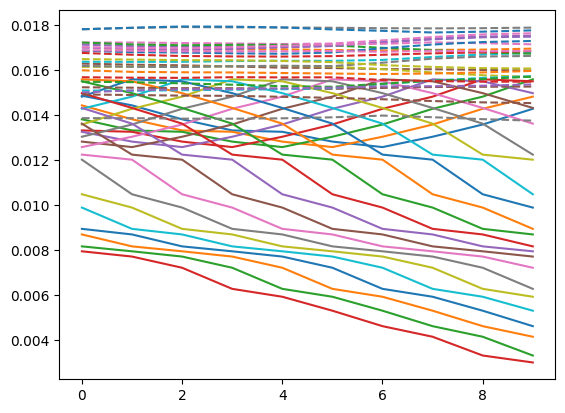

In [ ]:
# Überprüfe, ob das Modell auf der GPU oder der CPU ist
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Das Modell auf das entsprechende Gerät verschieben
model.to(device)

# Die Eingabedaten auch auf das gleiche Gerät verschieben
x_test = x_test.to(device)

# Vorhersagen mit dem Modell
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

print(x_test.shape)
print(y_pred.shape)
print(y_test.shape)
# Plotten der Ergebnisse
plt.plot(y_test.numpy(), label="Echter Wasserstand")
plt.plot(y_pred.cpu().numpy(), label="Vorhergesagter Wasserstand", linestyle="dashed")
#plt.legend()
plt.show()
